In this notebook we create the first embrional state of our Articial Society Model for traders network.
Here we'll make the transition from the concept of random traders to "fish", almost zero-intelligence agents who would make random choices but are bonded to a network of other traders which may influece its choices.  
Objectives for this notebook are:
* Fish agents have a wallet and when they're approaching 0 wealth they'll try to survive, by not trading, or by waiting their next cash income. Each fish has a different threshold for going in "survive" mode in order to not create clusters of price where all fishes are trading and other clusters when no one is trading.
* Fishes can have multiple positions. Since only 1 market is considered this should be easy to handle.
* Fishes have a sleep mode (even when they're not in survive mode they can deactivate for any reason, atm random)
* Link creation, based on limited knowledge, fishes will not blindly follow another agent's position but will be influeced (probability from trust matrix)

In [21]:
%run _config.ipynb

In [171]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    alfa = model.Price * 0.1 # coefficient for price updating
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'long':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'short':
            sso += agent_orders[i]
    
    delta = alfa * (sbo - sso)
    
    model.Last_Price = model.Price
    model.Price = model.Price + delta
    
    return model.Price

### Fish Agent

In [172]:
dic = {'step_1': [10, 'long', 1], 'step_2': [9, 'long', 2], 'step_3': [10, 'long', 1]}

In [173]:
def calculate_profit(init_price, position, shares, price_today):
    # distinction on long and short positions
    if position == 'long':
        return shares * price_today
    elif position == 'short':
        return shares * (2 * init_price - price_today)

In [174]:
cash = 390

l = list()
positions_to_sell = 'short'
price_today = 5

cash_out = 0
for key, value in dic.items():
    if value[1] == positions_to_sell:
        l.append(key)
        # calculate profit and add to cash for that key
        cash_out += calculate_profit(value[0], value[1], value[2], price_today)

cash += cash_out # convert position in cash and delete key from positions book
for key in l:
    del dic[key]
    
print(cash)

390


In [175]:
def add_new_order(wallet, step, price, position, order):
    # wallet is a dictionary {'step': [price, position, order]}
    wallet |= {f'step_{step}': [price, position, order]}
    return wallet

In [202]:
def remove_orders(wallet, cash, price_today, n_orders, positions_to_sell):
    print(f'in particular i will sell {positions_to_sell} positions')
    l = list()
    cash_out = 0; shares = 0
    for key, value in wallet.items():
        if value[1] == positions_to_sell:
            l.append(key)
            # calculate profit and add to cash for that key
            cash_out += calculate_profit(value[0], value[1], value[2], price_today)
            shares += value[2]
            
    cash += cash_out # convert position in cash and delete key from positions book
    for key in l:
        del wallet[key]
    
    return wallet, cash, shares

In [230]:
class Fish(mesa.Agent):
    def __init__(self, unique_id, model, init_cash):
        super().__init__(unique_id, model)
        
        # ID's
        self.type = 'fish'
        self.unique_id = unique_id
        self.node_id = None
        
        # Agent
        #self.cash = round(init_cash * ( 1. + 0.1 * random.uniform(-1, 1) ), 2)
        self.cash = init_cash
        self.wallet = dict()
        self.wealth = self.cash
        
        self.position = 'null'
        self.order = 0
        
        # Agent's Thresholds
        self.cash_thr = 20
        self.survive_mode = False
        
        # Knowledge Base
        self.neighbors = dict()
        
    # ~-~-~-~-~-~-~-~- functions ~-~-~-~-~-~-~-~-
    def buy_position(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'long'
            self.order = 1 #randomize also this later
        else:
            self.position = 'short'
            self.order = 1
        
        print(f'n particular i decided to buy a {self.position} position')
        self.wallet = add_new_order(self.wallet, step, self.Price, self.position, self.order)
        self.cash = self.cash - self.order * self.Price
    
    def sell_positions(self): # Note that positions is plural and for buy_position NOT
        self.position = random.choice(['long', 'short'])
        self.wallet, self.cash, self.order = remove_orders(self.wallet, self.cash, self.Price, random.randint(1, 2), self.position)
        
    # ~-~-~-~-~-~-~-~- see, next, action ~-~-~-~-~-~-~-~-
    def _see(self):
        self.Price = model.Price
        
    def _next(self):
        self.survive_mode = False if self.cash > self.cash_thr else True
        
    def _action(self):
        # today fish should only decide to buy or to sell positions, no both, otherwise it's a mess
        if self.survive_mode == False:
            if random.uniform(0, 1) < 0.5:
                print('i decided to buy positions')
                self.buy_position()
            else:
                print('i decided to sell positions')
                self.sell_positions()
        else:
            # if they are in survive_mode they can actually try to gain some cash back by selling their orders
            if random.uniform(0, 1) < 0.7:
                self.sell_positions()

    # ~-~-~-~-~-~-~-~- step function ~-~-~-~-~-~-~-~-
    def step(self):
        print('\nstep:', step, 'price:', self.model.Price)
        #if random.uniform(0, 1.0) < 0.10:
        #    self.cash += 10
        
        self._see()
        self._next()
        self._action()
        print('wallet:', self.wallet)
        print('cash:', self.cash)

In [231]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Fishes
        N_fishes = N_agents
        init_cash = 400
        
        for a in range(N_fishes):
            unique_id = f'fish_{a}'
            ag = Fish(unique_id, self, init_cash)
            self.schedule.add(ag)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
    def step(self): 
        
        #step the groups and agents
        self.schedule.step()
        
        # Collect data at that timestep
        self.datacollector.collect(self)

In [232]:
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 1, Price = 10)
    
    N_steps = 100
    for step in range(N_steps):
        model.step()


step: 0 price: 10
i decided to sell positions
in particular i will sell long positions
wallet: {}
cash: 400

step: 1 price: 10.0
i decided to buy positions
n particular i decided to buy a long position
wallet: {'step_1': [10.0, 'long', 1]}
cash: 390.0

step: 2 price: 11.0
i decided to buy positions
n particular i decided to buy a short position
wallet: {'step_1': [10.0, 'long', 1], 'step_2': [11.0, 'short', 1]}
cash: 379.0

step: 3 price: 9.9
i decided to sell positions
in particular i will sell short positions
wallet: {'step_1': [10.0, 'long', 1]}
cash: 391.1

step: 4 price: 8.91
i decided to buy positions
n particular i decided to buy a long position
wallet: {'step_1': [10.0, 'long', 1], 'step_4': [8.91, 'long', 1]}
cash: 382.19

step: 5 price: 9.801
i decided to sell positions
in particular i will sell long positions
wallet: {}
cash: 401.792

step: 6 price: 11.7612
i decided to sell positions
in particular i will sell short positions
wallet: {}
cash: 401.792

step: 7 price: 11.7612

In [233]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

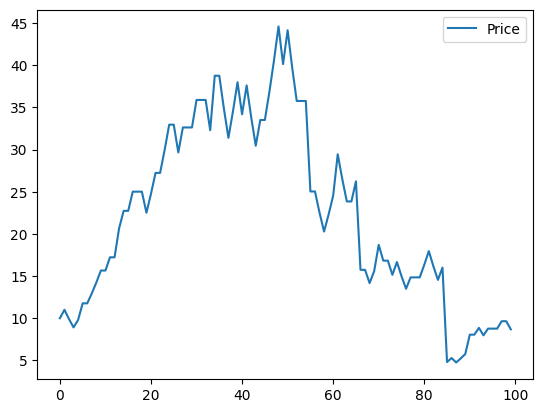

In [234]:
model_vars.plot();
#plt.yscale('log')

Actual ideas implemented:
* Fishes better have a random probability of getting an outside income of cash for trading instead of a periodized behaviour like savers
* In order to manage multiple orders we change wallet from being an int to be dictionary.  
**Observation on updating wallet:** Fishes can only make 1 order per day, because of the nature of the orderbook (change_prices and sso vs sbo) BUT if they have multiple orders they can actually sell all of them (of 1 type only! Not clear how to manage mixed wallets sell-offs). E.g. fish_1 has two short orders, he can sell all of them at the same time. If he has one short order and one long order he can only liquidate one of them that day (because otherwise it's a mess for calculating sso and sbo).
* Fishes sell their positions in a random way with a random probability.

Notes for next programming session:
* Fishes can decide to sell positions while they don't know if they have some, e.g. they may choose to sell long positions but they have none. So they'll sell nothing, it's still a little thing that may give problems. I fixed self.order problems for when not doing anything.
* Looks like at the moment a bubble effect derives from big selloffs of just 1 fish, this is because randint for how many positions to liquidate is not yet set (fishes will close either all long or short positions), hey this can be an idea for creating whales and getting a wyckoff dynamic.